In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd as ag
import numpy as np 
import os
import copy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import corner
import pyccl as ccl

from tqdm import tqdm, trange

from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import curve_fit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.decomposition import PCA


from numpy.polynomial import Chebyshev

import src.datamaker as datamaker
import src.training as training
import src.models as models

from importlib import reload
reload(datamaker)
reload(training)
reload(models)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

In [2]:
n_samples = 2048
n_tasks = 500

filename = 'data/Cgg_samples_{}tasks_{}samples.npz'.format(n_tasks, n_samples)

# Load in training data
if os.path.isfile(filename):
    with np.load(filename) as data:
        X_train = data['X_train']
        Y_train = data['Y_train']
        ell_bins = data['ell_bins']
        survey_midpoints = data['survey_midpoints']
        survey_pz = data['survey_pz']
        qrd_pz = data['qrd_pz']

print(X_train.shape)
print(Y_train.shape)

(500, 2048, 6)
(500, 2048, 30)


100%|██████████| 499/499 [00:14<00:00, 35.54it/s]


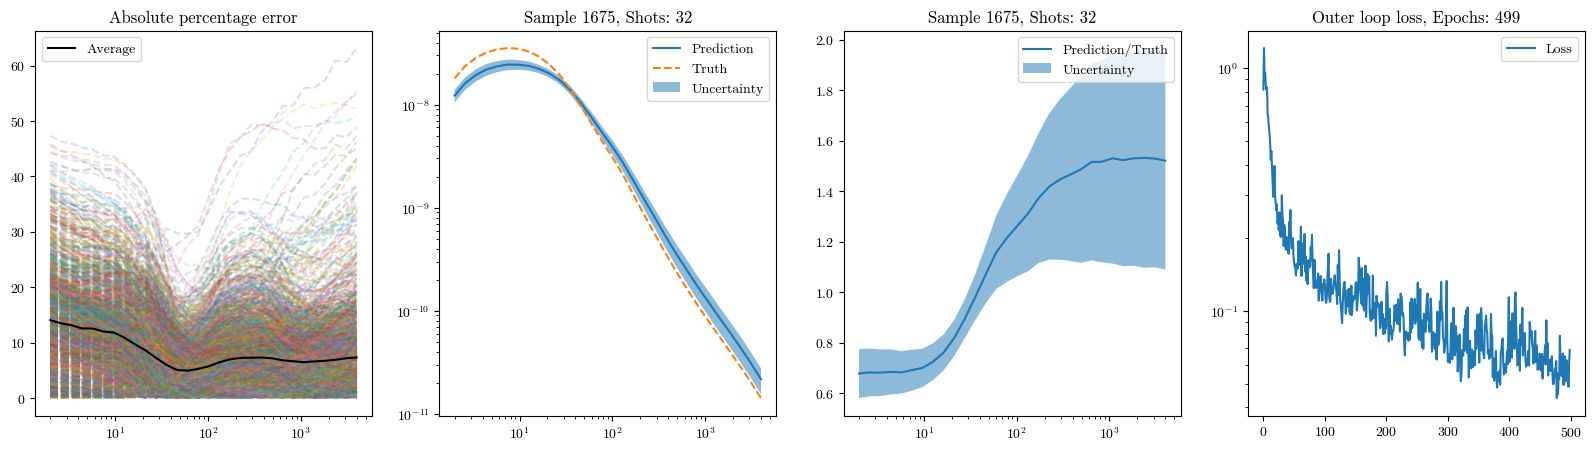

In [19]:
reload(training)
reload(models)

model = models.DropoutMLP(
            in_size=X_train.shape[2],
            hidden_size=512,
            out_size=Y_train.shape[2],
            dropout_rate=0.5
        )

# Take logarithm of spectra in Y_train
Y_train_log = np.log(Y_train)

# MAML train model
CosyMAML_log = training.Adam_MAML(
            model=model,
            seed=42
        )

y_pred_all, y_all_comp, y_pred_std, loss_MAML_log = CosyMAML_log.meta_train(
    x_train=X_train,
    y_train=Y_train_log,
    inner_lr=0.001,
    outer_lr=0.01,
    inner_decay=1e-5,
    outer_decay=1e-4,
    loss_fn=nn.MSELoss(),
    spt_frac=0.5,
    outer_epochs=1,
    inner_epochs=5,
    plot_prog=False,
    n_shots=32,
    ell_bins=ell_bins,
)

In [28]:
class Adam_MAML():
    '''
        Class for MAML implementation of an angular power spectrum emulator.
        Uses Adam optimizer instead of SGD.
    '''
    def __init__(self,
                 model,
                 loss_fn=nn.MSELoss(),
                 inner_lr=0.001,
                 outer_lr=0.01,
                 inner_decay=1e-5,
                 outer_decay=1e-4,
                 seed=14,
                 beta1=0.9,
                 beta2=0.999,
                 epsilon=1e-8,
                 device=None
                 ):
        
        self.model = model
        self.seed = seed

        if device is None:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = device
        self.model.to(self.device)

        self.rng = np.random.RandomState(seed)
        
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.inner_adam_params = self._init_adam_params()
        self.outer_adam_params = self._init_adam_params()

        # Initialise scalers for training
        self.scaler_x = training.TorchStandardScaler()
        self.scaler_y = training.TorchStandardScaler()

        # Initialise scalers for plotting
        self.scaler_x_plot = training.TorchStandardScaler()
        self.scaler_y_plot = training.TorchStandardScaler()

        # Initialise loss function
        self.loss_fn = loss_fn

        # Initialise learning rates and decay
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.inner_decay = inner_decay
        self.outer_decay = outer_decay

    def _init_adam_params(self):
        """Initialize the Adam optimizer parameters for each model parameter."""
        adam_params = {}
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                adam_params[name] = {
                    'm': torch.zeros_like(param.data).to(self.device),
                    'v': torch.zeros_like(param.data).to(self.device),
                    't': 0
                }
        return adam_params

    # convert numpy array to torch tensor
    def _to_torch(self, arr):
        return ag.Variable(torch.tensor(arr, dtype=torch.float32).to(self.device))
    
    def _split_spt_qry(self, x_train, y_train, task, spt_frac):

        # Shuffle indices and split into support and query sets
        spt_size = int(spt_frac * n_samples)
        permu = self.rng.permutation(n_samples)
        spt_inds = permu[:spt_size]
        qry_inds = permu[spt_size:]

        # Select support and query data, then scale appropriately
        x_spt_raw = x_train[task][spt_inds, :]
        y_spt_raw = y_train[task][spt_inds, :]
        x_qry_raw = x_train[task][qry_inds, :]
        y_qry_raw = y_train[task][qry_inds, :]

        x_spt = self.scaler_x.fit_transform(x_spt_raw)
        y_spt = self.scaler_y.fit_transform(y_spt_raw)

        x_qry = self.scaler_x.transform(x_qry_raw)
        y_qry = self.scaler_y.transform(y_qry_raw)

        return x_spt, y_spt, x_qry, y_qry
    
    def _split_shot_test(self, x_train, y_train, task_plot, rand_inds):
        
        test_inds = np.arange(len(x_train[0]))
        test_inds = np.delete(test_inds, rand_inds)

        x_shot = x_train[task_plot, rand_inds]
        y_shot = y_train[task_plot, rand_inds]

        # Fit scaler on support data and transform both support and test data
        x_shot = self.scaler_x_plot.fit_transform(x_shot)
        y_shot = self.scaler_y_plot.fit_transform(y_shot)

        x_test = x_train[task_plot, test_inds]
        x_test = self.scaler_x_plot.transform(x_test)
        y_test = y_train[task_plot, test_inds]
        y_test = self.scaler_y_plot.transform(y_test)
        
        return x_shot, y_shot, x_test, y_test
    
    def _update_adam_params(self, adam_params, step):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                adam_state = adam_params[name]
                grad = param.grad.data
                # Update biased first moment estimate
                adam_state['m'] = self.beta1 * adam_state['m'] + (1 - self.beta1) * grad
                # Update biased second raw moment estimate
                adam_state['v'] = self.beta2 * adam_state['v'] + (1 - self.beta2) * (grad ** 2)
                adam_state['t'] += 1

                # Compute bias-corrected first moment estimate
                m_hat = adam_state['m'] / (1 - self.beta1 ** adam_state['t'])
                # Compute bias-corrected second raw moment estimate
                v_hat = adam_state['v'] / (1 - self.beta2 ** adam_state['t'])

                # Update parameters
                param.data -= step * m_hat / (torch.sqrt(v_hat) + self.epsilon)
    
    # send individual data batch to model for training step
    def _train_on_batch(self, x, y, adam_params, step):
        
        # Check if model has dropout layers and if so enable dropout
        if hasattr(self.model, 'dropout'):
            self.model.train()

        # Zero gradients before training
        self.model.zero_grad()
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred, y)
        loss.backward() # backpropagate loss

        # Update model parameters using Adam optimizer
        self._update_adam_params(adam_params, step)

    def _finetune(self, x_train, y_train, adapt_steps, safe=True, x_test=None):
        # In safe mode, model is reset to pre-finetuning weights after fine-tuning
        if safe:
            weights_before = copy.deepcopy(self.model.state_dict())

        # Initialise new adam parameters for fine-tuning
        adam_params = self._init_adam_params()

        # Fine-tune model on shot data
        for i in range(adapt_steps):
            innerstep = self.inner_lr * (1 - i * self.inner_decay)
            self._train_on_batch(x_train, y_train, adam_params, innerstep)

        # Reset model to pre-finetuning weights and return a prediction
        if safe:
            self.model.eval()
            y_pred = self.model(x_test)
            self.model.load_state_dict(weights_before)
            return y_pred

    def _plot_progress(self, i, x_shot, y_shot, x_test, y_test, ell_bins):

        # Create a deepcopy of the model to reset after fine-tuning
        weights_before = copy.deepcopy(self.model.state_dict())

        n_shots = x_shot.shape[1] # Number of shots for fine-tuning

        # Initial prediction before fine-tuning
        y_pred = self.model(x_test)
        loss = self.loss_fn(y_pred, y_test)

        # Transform prediction back to original space
        y_pred = self.scaler_y_plot.inverse_transform(y_pred)
        y_pred = y_pred.detach().cpu().numpy()
        y_pred = np.exp(y_pred)

        # Transform test data for comparison
        y_test_comp = self.scaler_y_plot.inverse_transform(y_test)
        y_test_comp = y_test_comp.detach().cpu().numpy()
        y_test_comp = np.exp(y_test_comp)

        # Compute mean absolute percentage error
        _, err_avg = self._compute_mape(y_pred, y_test_comp)

        # Inititalise plot
        plt.cla()
        plt.title('Epoch: %d, Shots: %d' % (i+1, n_shots))
        plt.plot(ell_bins, err_avg, label='MAML iter 0', ls='-')

        plots = int(32/8) # Plot every 8 shots
        for plot in range(plots):
            self._finetune(x_shot, y_shot, 8, safe=False) # Fine-tune model on shots
            y_pred = self.model(x_test)
            loss = self.loss_fn(y_pred, y_test)

            # Transform prediction back to original space
            y_pred = self.scaler_y_plot.inverse_transform(y_pred)
            y_pred = y_pred.detach().cpu().numpy()
            y_pred = np.exp(y_pred)

            _, err_avg = self._compute_mape(y_pred, y_test_comp)

            plt.plot(ell_bins, err_avg, label='MAML iter %d' % ((plot+1)*8), ls='-')

        plt.legend()
        plt.xlabel(r'$\ell$')
        plt.ylabel('Avg. MAPE')
        plt.title('Loss: %.4f' % loss)
        plt.pause(0.01)

        # Reload pre-inner loop weights for the next task
        self.model.load_state_dict(weights_before)

        del weights_before, y_pred, y_test_comp, loss

    def _compute_mape(self, y_pred, y_test):

        err = np.empty((y_pred.shape[0], y_pred.shape[1]))
        for k in range(y_pred.shape[0]):
            err[k] = abs(y_pred[k,:] - y_test[k,:])/y_test[k,:] * 100
        err_avg = np.mean(err, axis=0)

        return err, err_avg
    
    # Primary training function for MAML to be called by user
    def meta_train(self, x_train, y_train,
                   spt_frac, outer_epochs, inner_epochs, n_shots=5,
                   rec_loss=True, plot_prog=False, plot_summary=True, ell_bins=None):
        
        # Check if ell_bins are provided, if not just plot against index
        if ell_bins is None:
            ell_bins = np.arange(y_train.shape[2])
        
        # move data to torch tensors
        x_train = self._to_torch(x_train)
        y_train = self._to_torch(y_train)
        
        # ascertaining the number of tasks and samples
        n_tasks = y_train.shape[0]
        n_samples = y_train.shape[1]
        tasks = np.arange(n_tasks)
        tasks = self.rng.permutation(tasks) # permute the order tasks are trained

        # Isolate a random task for checking the progress of training
        task_plot = self.rng.choice(tasks, size=1)
        tasks = np.delete(tasks, task_plot)
        n_tasks = len(tasks)
        rand_inds = self.rng.choice(n_samples, size=n_shots, replace=False)

        # Split test plot data into support and query sets
        x_shot, y_shot, x_test, y_test = self._split_shot_test(x_train, y_train, task_plot, rand_inds)

        # Repeat tasks so total meta train epochs is satisfied
        if n_tasks < (outer_epochs*n_tasks):
            tasks = np.tile(tasks, int(np.ceil(outer_epochs*n_tasks/n_tasks))) 
        
        loss_rec = [] # list to record meta loss
        progress = tqdm(range(outer_epochs*len(tasks))) # Progress bar for training

        # Outer loop
        for i, task in enumerate(tasks):
            # Create a deepcopy of the model to reset after both inner and outer loops
            weights_before = copy.deepcopy(self.model.state_dict())

            # Split data into support and query sets
            x_spt, y_spt, x_qry, y_qry = self._split_spt_qry(x_train, y_train, task, spt_frac)

            # Inner loop: Train on support data
            for j in range(inner_epochs):
                innerstep = self.inner_lr * (1 - j * self.inner_decay)
                self._train_on_batch(x_spt, y_spt, self.inner_adam_params, innerstep)

            # Check if model has dropout layers and if so enable dropout
            if hasattr(self.model, 'dropout'):
                self.model.train()

            # Outer loop: Evaluate and update using query data
            outerstep = self.outer_lr * (1 - i * self.outer_decay)

            self.model.zero_grad()
            y_pred = self.model(x_qry)
            loss = self.loss_fn(y_pred, y_qry)
            loss.backward() # backpropagate loss
            loss_rec.append(loss.item()) # Record loss

            # Reload pre-inner loop weights for the next task
            self.model.load_state_dict(weights_before)

            # Update progress bar
            progress.update(1)

            # Update weights using Adam for outer loop
            self._update_adam_params(self.outer_adam_params, outerstep)

            # Plot progress every n_tasks/10 outer epochs
            # Progress is measured as how quickly and accurately 
            # the model can adapt to a new task
            if (i+1) % int(len(tasks)/10) == 0 and plot_prog:
                self._plot_progress(i, x_shot, y_shot, x_test, y_test, ell_bins)

        progress.close()

        # Plot a final summary of the model
        if plot_summary:
            
            # Create a deepcopy of the model to reset after fine-tuning
            weights_before = copy.deepcopy(self.model.state_dict())

            # Finetune model on all shots
            self._finetune(x_shot, y_shot, adapt_steps=32, safe=False)
            
            # Plot summary of model
            self.plot_summary(x_test, y_test, ell_bins, outer_epochs, loss_rec, n_shots)

            # Reset model to pre-finetuning weights
            self.model.load_state_dict(weights_before)

        if rec_loss:
            return loss_rec
                
    def plot_summary(self, x_test, y_test, ell_bins, outer_epochs, loss_rec, n_shots):
        
        # Enable dropout for final prediction to get uncertainty estimates
        if hasattr(self.model, 'dropout'):
            y_pred_all = []
            for i in range(100):
                y_pred = self.model(x_test)
                y_pred = self.scaler_y_plot.inverse_transform(y_pred)
                y_pred = y_pred.detach().cpu().numpy()
                y_pred = np.exp(y_pred)
                y_pred_all.append(y_pred)

            y_pred_all = np.array(y_pred_all)
            # Standard deviation of predictions
            y_pred_std = np.std(y_pred_all, axis=0)
            y_pred_all = np.mean(y_pred_all, axis=0)
        else:
            y_pred = self.model(x_test)
            y_pred = self.scaler_y_plot.inverse_transform(y_pred)
            y_pred = y_pred.detach().cpu().numpy()
            y_pred_all = np.exp(y_pred)

        y_all_comp = self.scaler_y_plot.inverse_transform(y_test)
        y_all_comp = y_all_comp.detach().cpu().numpy()
        y_all_comp = np.exp(y_all_comp)

        err, err_avg = self._compute_mape(y_pred_all, y_all_comp)

        _, axs = plt.subplots(1, 4, figsize=(20, 5))
        for i in range(len(err)):
            axs[0].plot(ell_bins, err[i], ls='-', alpha=0.1)
        axs[0].plot(ell_bins, err_avg, ls='-', c='k', label='Average')
        axs[0].legend()
        axs[0].set_ylim(0, 100)
        axs[0].set_xscale('log')
        axs[0].set_title('Absolute percentage error')

        # Select worst performing sample for plotting
        worst_sample = np.argmax(np.mean(err, axis=1))
        axs[1].plot(ell_bins, y_pred_all[worst_sample], label='Prediction')
        axs[1].plot(ell_bins, y_all_comp[worst_sample], label='Truth', ls='--')
        if hasattr(self.model, 'dropout'):
            axs[1].fill_between(ell_bins, y_pred_all[worst_sample]-y_pred_std[worst_sample],
                                y_pred_all[worst_sample]+y_pred_std[worst_sample],
                                alpha=0.5, label='Uncertainty')
        axs[1].legend()
        axs[1].set_title('Sample %d, Shots: %d' % (worst_sample, n_shots))
        axs[1].set_xscale('log')
        axs[1].set_yscale('log')

        axs[2].plot(ell_bins, y_pred_all[worst_sample]/y_all_comp[worst_sample], 
                    label='Prediction/Truth')
        if hasattr(self.model, 'dropout'):
            axs[2].fill_between(ell_bins, 
                                (y_pred_all[worst_sample]-y_pred_std[worst_sample])/y_all_comp[worst_sample],
                                (y_pred_all[worst_sample]+y_pred_std[worst_sample])/y_all_comp[worst_sample],
                                alpha=0.5, label='Uncertainty')
        axs[2].set_xscale('log')
        axs[2].legend()
        axs[2].set_title('Sample %d, Shots: %d' % (worst_sample, n_shots))
        axs[3].plot(loss_rec, label='Loss')
        axs[3].set_yscale('log')
        axs[3].legend()
        axs[3].set_title('Outer loop loss, Epochs: %d' % (outer_epochs*n_tasks))

        plt.savefig('maml_output_final.pdf', bbox_inches='tight') 

100%|██████████| 499/499 [00:11<00:00, 42.50it/s]


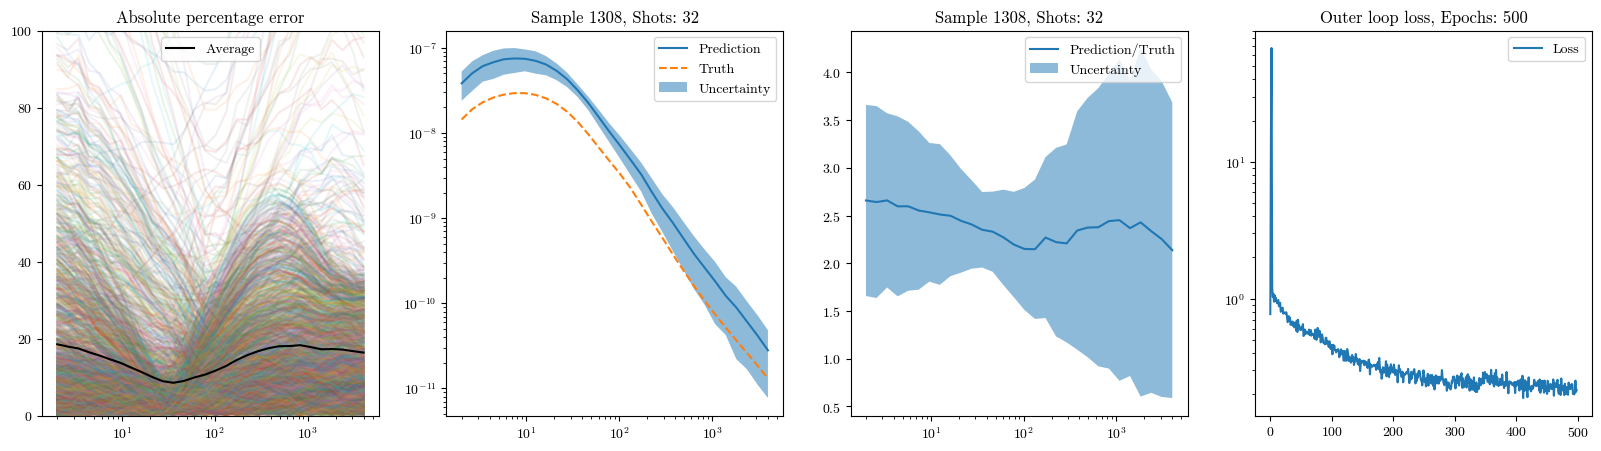

In [29]:
model = models.DropoutMLP(
            in_size=X_train.shape[2],
            hidden_size=512,
            out_size=Y_train.shape[2],
            dropout_rate=0.5
        )

# Take logarithm of spectra in Y_train
Y_train_log = np.log(Y_train)

# MAML train model
CosyMAML_log = Adam_MAML(
            model=model,
            loss_fn=nn.MSELoss(),
            inner_lr=0.001,
            outer_lr=0.01,
            inner_decay=1e-5,
            outer_decay=1e-4,
            seed=14,
            beta1=0.9,
            beta2=0.999,
            epsilon=1e-8,
            device='cuda'
        )

CosyMAML_log.meta_train(
    x_train=X_train,
    y_train=Y_train_log,
    spt_frac=0.5,
    outer_epochs=1,
    inner_epochs=5,
    n_shots=32,
    rec_loss=False,
    plot_prog=False,
    plot_summary=True,
    ell_bins=ell_bins
)